In [1]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis

In [2]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [4]:
with open('results/02/results.txt', 'r') as file:
    best_ae_model_path = file.readline().strip()

In [5]:
with open('results/02/best_trial_params.json', 'r') as json_file:
    best_model_params = json.load(json_file)

print(best_model_params)

{'latent_size': 22, 'n_layers': 2, 'dropout': 0.013875149619123436}


In [6]:
cancer_autoencoder = CancerDataAutoEncoder.load_from_checkpoint(
    best_ae_model_path,
    **best_model_params
)

In [7]:
import random


class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU):
        super(SimpleNN, self).__init__()
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x)

simple_nn = SimpleNN(
    input_dim=best_model_params['latent_size'],
    n_layers=8
)

In [8]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(BaseCancerRegressor(cancer_autoencoder, simple_nn), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCancerRegressor                      [1, 1]                    --
├─CancerDataAutoEncoder: 1-1             --                        1,489,664
│    └─Sequential: 2-1                   [1, 22]                   --
│    │    └─Linear: 3-1                  [1, 506]                  (500,940)
│    │    └─ReLU: 3-2                    [1, 506]                  --
│    │    └─Dropout: 3-3                 [1, 506]                  --
│    │    └─Linear: 3-4                  [1, 23]                   (11,661)
│    │    └─ReLU: 3-5                    [1, 23]                   --
│    │    └─Dropout: 3-6                 [1, 23]                   --
│    │    └─Linear: 3-7                  [1, 22]                   (528)
├─SimpleNN: 1-2                          [1, 1]                    --
│    └─Sequential: 2-2                   [1, 1]                    --
│    │    └─Linear: 3-8                  [1, 44]              

In [9]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = BaseCancerRegressor(
        cancer_autoencoder,
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=3,
            dropout=.3,
            activation=nn.LeakyReLU,
        ),
        lr=0.003,
        weight_decay=0.004,
        optimizer=torch.optim.Adam,
    )
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [10]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     467.0550537109375     │
│         test_mse          │     467.0550537109375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 467.0550537109375, 'test_mse': 467.0550537109375}]

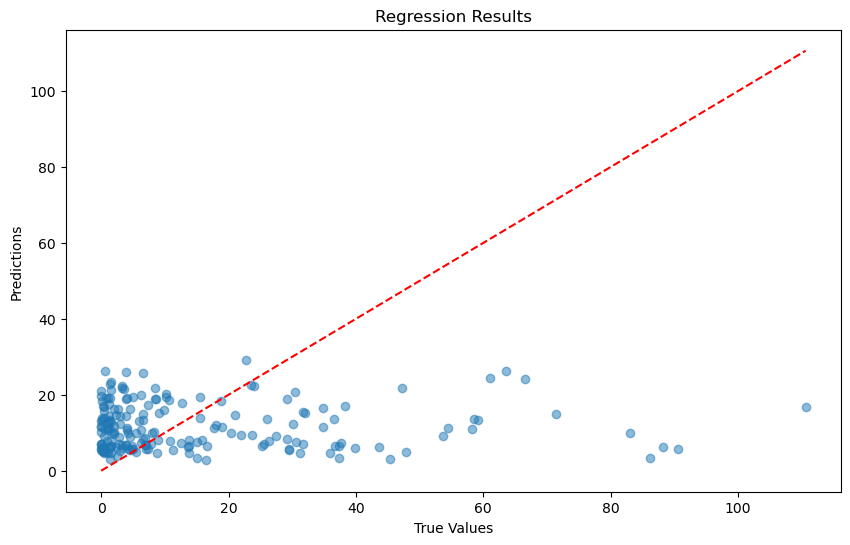

In [11]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = model(x)
            y_true.append(y)
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

In [12]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 15)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model = BaseCancerRegressor(
        CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=n_layers,
            dropout=dropout,
            activation=activation,
        ),
        lr=learning_rate,
        weight_decay=weight_decay,
        optimizer=optimizer,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [13]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="ae_regressor_study")
study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-18 12:13:52,133] A new study created in memory with name: ae_regressor_study


  0%|          | 0/100 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:14:41,995] Trial 0 finished with value: 1027.2843017578125 and parameters: {'n_layers': 15, 'dropout': 0.28269376397251755, 'learning_rate': 0.0023068827570659604, 'weight_decay': 0.0002338892803798945, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 0 with value: 1027.2843017578125.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:16:18,969] Trial 1 finished with value: 676.1420288085938 and parameters: {'n_layers': 14, 'dropout': 0.2852498150333585, 'learning_rate': 0.0088037143782524, 'weight_decay': 0.00296677534277553, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:16:52,917] Trial 2 finished with value: 1048.2789306640625 and parameters: {'n_layers': 14, 'dropout': 0.1338194791881152, 'learning_rate': 0.0002152113585411131, 'weight_decay': 7.618780912303598e-05, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:17:43,909] Trial 3 finished with value: 1033.5028076171875 and parameters: {'n_layers': 6, 'dropout': 0.1705428239365238, 'learning_rate': 0.00014918222285909005, 'weight_decay': 0.0004090791519789148, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:18:38,675] Trial 4 finished with value: 682.2605590820312 and parameters: {'n_layers': 12, 'dropout': 0.3618756607868423, 'learning_rate': 0.000588907303362588, 'weight_decay': 0.0009700525473474125, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:19:07,096] Trial 5 finished with value: 1034.70947265625 and parameters: {'n_layers': 10, 'dropout': 0.19047786417253887, 'learning_rate': 0.0005313916003828828, 'weight_decay': 0.0001619833691370118, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:21:29,143] Trial 6 finished with value: 717.631103515625 and parameters: {'n_layers': 11, 'dropout': 0.28564945170789036, 'learning_rate': 0.0023753500359332603, 'weight_decay': 0.00029473630167862287, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:22:59,798] Trial 7 finished with value: 686.275390625 and parameters: {'n_layers': 14, 'dropout': 0.26484533779929215, 'learning_rate': 0.0007106705923566722, 'weight_decay': 2.1229525699875453e-05, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.4 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.4 K     Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.021     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:27:01,553] Trial 8 finished with value: 748.3578491210938 and parameters: {'n_layers': 3, 'dropout': 0.046384394495612935, 'learning_rate': 0.000808848252642974, 'weight_decay': 0.00031338681341836345, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:27:42,610] Trial 9 finished with value: 784.19775390625 and parameters: {'n_layers': 5, 'dropout': 0.03864060750413423, 'learning_rate': 0.0006635094707669844, 'weight_decay': 2.9021273536651932e-05, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:27:57,259] Trial 10 finished with value: 1034.12353515625 and parameters: {'n_layers': 8, 'dropout': 0.47404634079791036, 'learning_rate': 1.220856885341842e-05, 'weight_decay': 0.009320344787145725, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:28:24,439] Trial 11 finished with value: 703.6730346679688 and parameters: {'n_layers': 12, 'dropout': 0.4093117997707871, 'learning_rate': 0.009822701206126059, 'weight_decay': 0.002506846527674664, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:29:02,628] Trial 12 finished with value: 1017.3145751953124 and parameters: {'n_layers': 12, 'dropout': 0.36524036691135076, 'learning_rate': 7.021496079028655e-05, 'weight_decay': 0.0015178551507046556, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.633    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:29:42,677] Trial 13 finished with value: 759.424072265625 and parameters: {'n_layers': 13, 'dropout': 0.3728564537745268, 'learning_rate': 0.008072196612517816, 'weight_decay': 0.0015846253947912252, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 1 with value: 676.1420288085938.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:30:27,774] Trial 14 finished with value: 675.7716674804688 and parameters: {'n_layers': 9, 'dropout': 0.3270951531238503, 'learning_rate': 0.0031777340684198464, 'weight_decay': 0.006089110189217094, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 14 with value: 675.7716674804688.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:31:56,877] Trial 15 finished with value: 738.2905883789062 and parameters: {'n_layers': 8, 'dropout': 0.21708823055489065, 'learning_rate': 0.0029369463501034373, 'weight_decay': 0.009170280601648494, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 14 with value: 675.7716674804688.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:34:15,356] Trial 16 finished with value: 670.7393188476562 and parameters: {'n_layers': 9, 'dropout': 0.4869834606363541, 'learning_rate': 0.004327406308432803, 'weight_decay': 0.004273829132058633, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 16 with value: 670.7393188476562.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:35:00,396] Trial 17 finished with value: 680.0958251953125 and parameters: {'n_layers': 9, 'dropout': 0.4705482189571629, 'learning_rate': 0.004011069877900493, 'weight_decay': 0.003967611691973034, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 16 with value: 670.7393188476562.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:37:27,431] Trial 18 finished with value: 677.2786865234375 and parameters: {'n_layers': 6, 'dropout': 0.42569809432562533, 'learning_rate': 0.0014818109083691974, 'weight_decay': 0.0007371869672996082, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 16 with value: 670.7393188476562.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:40:54,151] Trial 19 finished with value: 934.0087280273438 and parameters: {'n_layers': 8, 'dropout': 0.4942998338434728, 'learning_rate': 4.884384687352988e-05, 'weight_decay': 0.0052649496351588835, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 16 with value: 670.7393188476562.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:41:11,934] Trial 20 finished with value: 675.0477294921875 and parameters: {'n_layers': 10, 'dropout': 0.337852291843301, 'learning_rate': 0.004655434809748981, 'weight_decay': 0.004852531283214051, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 16 with value: 670.7393188476562.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:41:27,335] Trial 21 finished with value: 674.8873901367188 and parameters: {'n_layers': 10, 'dropout': 0.33140093782632685, 'learning_rate': 0.0047474821942203, 'weight_decay': 0.005842135714806633, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 16 with value: 670.7393188476562.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:41:38,575] Trial 22 finished with value: 668.00732421875 and parameters: {'n_layers': 10, 'dropout': 0.42985259991126834, 'learning_rate': 0.00529794397283538, 'weight_decay': 0.002124756686925194, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:41:57,029] Trial 23 finished with value: 671.4339599609375 and parameters: {'n_layers': 10, 'dropout': 0.42824420835500004, 'learning_rate': 0.0013880221721344062, 'weight_decay': 0.002044542820362517, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:42:28,294] Trial 24 finished with value: 674.464111328125 and parameters: {'n_layers': 7, 'dropout': 0.43442293389294645, 'learning_rate': 0.0012788651456202879, 'weight_decay': 0.0017738693632393218, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:44:39,252] Trial 25 finished with value: 692.341796875 and parameters: {'n_layers': 11, 'dropout': 0.4435270388102512, 'learning_rate': 0.0013297957633657375, 'weight_decay': 0.0007214717845782331, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:45:23,394] Trial 26 finished with value: 675.1730346679688 and parameters: {'n_layers': 11, 'dropout': 0.39862584526598344, 'learning_rate': 0.00032512598836685543, 'weight_decay': 0.0011265244818768087, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:45:44,407] Trial 27 finished with value: 701.2000122070312 and parameters: {'n_layers': 9, 'dropout': 0.49560818102650495, 'learning_rate': 0.00590596726089035, 'weight_decay': 0.0026887076398190413, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:47:08,567] Trial 28 finished with value: 705.6688232421875 and parameters: {'n_layers': 7, 'dropout': 0.4563407400100617, 'learning_rate': 0.002084468251549514, 'weight_decay': 9.343717230124561e-05, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.052     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:48:23,587] Trial 29 finished with value: 1020.8004760742188 and parameters: {'n_layers': 4, 'dropout': 0.397307270878627, 'learning_rate': 0.002015690442933749, 'weight_decay': 0.0004566305514562686, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:49:21,666] Trial 30 finished with value: 1024.8494873046875 and parameters: {'n_layers': 10, 'dropout': 0.4553828157544119, 'learning_rate': 0.001056970751860747, 'weight_decay': 0.0023363210259838957, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:50:11,578] Trial 31 finished with value: 674.1568603515625 and parameters: {'n_layers': 7, 'dropout': 0.4346373320958587, 'learning_rate': 0.001873448213286688, 'weight_decay': 0.0016880394271655253, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:50:49,876] Trial 32 finished with value: 676.542724609375 and parameters: {'n_layers': 9, 'dropout': 0.4163091948826938, 'learning_rate': 0.006310684593827144, 'weight_decay': 0.0034192278100868257, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:51:13,210] Trial 33 finished with value: 671.1231079101562 and parameters: {'n_layers': 7, 'dropout': 0.49892525416966316, 'learning_rate': 0.0034583691710681113, 'weight_decay': 0.000615004857425434, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:52:00,089] Trial 34 finished with value: 676.78466796875 and parameters: {'n_layers': 6, 'dropout': 0.4863291647215744, 'learning_rate': 0.0034589959232566862, 'weight_decay': 0.0005504958512749197, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:52:31,616] Trial 35 finished with value: 675.3338012695312 and parameters: {'n_layers': 8, 'dropout': 0.3863293302979795, 'learning_rate': 0.0070238927430502345, 'weight_decay': 0.0011216030459677564, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:52:47,497] Trial 36 finished with value: 1030.2496337890625 and parameters: {'n_layers': 11, 'dropout': 0.49636666515202366, 'learning_rate': 0.00029512694323999094, 'weight_decay': 0.0007960047767797416, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:54:26,474] Trial 37 finished with value: 675.49609375 and parameters: {'n_layers': 5, 'dropout': 0.3065092306919214, 'learning_rate': 0.002787205962553737, 'weight_decay': 1.0629123153046601e-05, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:54:55,634] Trial 38 finished with value: 683.7428588867188 and parameters: {'n_layers': 10, 'dropout': 0.46264142066319663, 'learning_rate': 0.0047614013834875735, 'weight_decay': 0.0001059167530598066, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:55:08,855] Trial 39 finished with value: 1038.67822265625 and parameters: {'n_layers': 15, 'dropout': 0.1406223927764508, 'learning_rate': 0.0009240268781694824, 'weight_decay': 0.00018924058175545032, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.633    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:55:39,489] Trial 40 finished with value: 1022.7491455078124 and parameters: {'n_layers': 13, 'dropout': 0.3611630660973022, 'learning_rate': 0.0015846917372760163, 'weight_decay': 0.0037245657887028504, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:56:00,490] Trial 41 finished with value: 671.9578857421875 and parameters: {'n_layers': 7, 'dropout': 0.4380888097679353, 'learning_rate': 0.00215519487195397, 'weight_decay': 0.0019772275700286556, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.3 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.3 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.180     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:57:09,398] Trial 42 finished with value: 685.5658569335938 and parameters: {'n_layers': 7, 'dropout': 0.45221094938083367, 'learning_rate': 0.0004697920097622937, 'weight_decay': 0.0024018059347955343, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.053     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:57:22,980] Trial 43 finished with value: 686.6519165039062 and parameters: {'n_layers': 5, 'dropout': 0.41351378523833526, 'learning_rate': 0.0024073747456641215, 'weight_decay': 0.0010786390915347172, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 12:57:39,597] Trial 44 finished with value: 884.970458984375 and parameters: {'n_layers': 8, 'dropout': 0.07850975359216039, 'learning_rate': 0.005850302136128923, 'weight_decay': 0.001932272229875619, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:00:33,624] Trial 45 finished with value: 698.5904541015625 and parameters: {'n_layers': 9, 'dropout': 0.23728847497620192, 'learning_rate': 0.00013388754522543534, 'weight_decay': 0.007124473445125523, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 42.1 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
42.1 K    Trainable params
2.0 M     Non-trainable params
2.0 M     Total params
8.179     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:01:07,570] Trial 46 finished with value: 682.9439697265625 and parameters: {'n_layers': 6, 'dropout': 0.4702798923238736, 'learning_rate': 0.00390003669952691, 'weight_decay': 0.0013237226072038153, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 22 with value: 668.00732421875.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:02:01,568] Trial 47 finished with value: 664.7633666992188 and parameters: {'n_layers': 10, 'dropout': 0.3827451111130499, 'learning_rate': 0.009709449622608375, 'weight_decay': 0.00027351480899933685, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:02:56,924] Trial 48 finished with value: 671.7091064453125 and parameters: {'n_layers': 11, 'dropout': 0.003154745378905144, 'learning_rate': 0.007357358732696019, 'weight_decay': 0.0003334727877072719, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:03:39,442] Trial 49 finished with value: 666.8321533203125 and parameters: {'n_layers': 12, 'dropout': 0.3833007431238459, 'learning_rate': 0.009679622177020362, 'weight_decay': 0.0002274097247352787, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:04:46,870] Trial 50 finished with value: 680.318603515625 and parameters: {'n_layers': 12, 'dropout': 0.28652804704804996, 'learning_rate': 0.008094551934658488, 'weight_decay': 5.0112305679433924e-05, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.633    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:06:53,085] Trial 51 finished with value: 671.6222534179688 and parameters: {'n_layers': 13, 'dropout': 0.3793994226515228, 'learning_rate': 0.005006579326087774, 'weight_decay': 0.000149715718254917, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:09:28,011] Trial 52 finished with value: 673.2884521484375 and parameters: {'n_layers': 12, 'dropout': 0.3508709616307317, 'learning_rate': 0.009177134215561782, 'weight_decay': 0.00024213385043867628, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:10:28,276] Trial 53 finished with value: 669.7266235351562 and parameters: {'n_layers': 10, 'dropout': 0.4733545917470246, 'learning_rate': 0.009932658711554933, 'weight_decay': 0.0005370179439826334, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:11:28,871] Trial 54 finished with value: 670.7645263671875 and parameters: {'n_layers': 9, 'dropout': 0.4777747288175198, 'learning_rate': 0.00997619431610027, 'weight_decay': 0.0004857377911790968, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:12:20,023] Trial 55 finished with value: 674.8154907226562 and parameters: {'n_layers': 14, 'dropout': 0.4716208073779087, 'learning_rate': 0.009096069719740574, 'weight_decay': 0.000426617028921301, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:13:22,826] Trial 56 finished with value: 672.193115234375 and parameters: {'n_layers': 9, 'dropout': 0.3991307045214031, 'learning_rate': 0.009879054796514583, 'weight_decay': 0.0002446316403259757, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:13:57,082] Trial 57 finished with value: 1033.25390625 and parameters: {'n_layers': 10, 'dropout': 0.4773678106506655, 'learning_rate': 2.1098751389221544e-05, 'weight_decay': 0.0001451037870499944, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:14:55,151] Trial 58 finished with value: 686.8451538085938 and parameters: {'n_layers': 10, 'dropout': 0.4203270786563379, 'learning_rate': 0.006800076259895613, 'weight_decay': 0.00031867163575029765, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 47 with value: 664.7633666992188.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:16:51,976] Trial 59 finished with value: 660.7769165039062 and parameters: {'n_layers': 11, 'dropout': 0.3143379535809292, 'learning_rate': 0.00459661974900585, 'weight_decay': 0.00017998143379216285, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:19:18,808] Trial 60 finished with value: 674.2886352539062 and parameters: {'n_layers': 11, 'dropout': 0.3029526184098161, 'learning_rate': 0.004919790433064527, 'weight_decay': 5.7885129473603204e-05, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:21:48,377] Trial 61 finished with value: 679.0200805664062 and parameters: {'n_layers': 12, 'dropout': 0.2605389201704274, 'learning_rate': 0.005759874152979785, 'weight_decay': 0.00017171709438492478, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:22:51,053] Trial 62 finished with value: 672.9962768554688 and parameters: {'n_layers': 9, 'dropout': 0.3409189397862813, 'learning_rate': 0.00987846193121634, 'weight_decay': 0.0001196005605340459, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:23:56,124] Trial 63 finished with value: 673.1127319335938 and parameters: {'n_layers': 11, 'dropout': 0.381416151020881, 'learning_rate': 0.0070437858764217445, 'weight_decay': 0.00021543153219907648, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:25:00,807] Trial 64 finished with value: 670.6280517578125 and parameters: {'n_layers': 10, 'dropout': 0.3167848504856965, 'learning_rate': 0.004255786361904214, 'weight_decay': 0.000380682612411372, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:26:35,822] Trial 65 finished with value: 680.3504028320312 and parameters: {'n_layers': 10, 'dropout': 0.32613033517073786, 'learning_rate': 0.002984202925168244, 'weight_decay': 0.00034318819799424645, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.633    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:28:09,649] Trial 66 finished with value: 671.0299682617188 and parameters: {'n_layers': 13, 'dropout': 0.3621491010528025, 'learning_rate': 0.004030777028624483, 'weight_decay': 0.0002735007248845605, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:29:29,686] Trial 67 finished with value: 673.193115234375 and parameters: {'n_layers': 11, 'dropout': 0.305001831564766, 'learning_rate': 0.005698921036417714, 'weight_decay': 0.00012967394936050264, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:30:43,697] Trial 68 finished with value: 680.9874267578125 and parameters: {'n_layers': 12, 'dropout': 0.18631483515185598, 'learning_rate': 0.003628008479018443, 'weight_decay': 0.0008766855253254847, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:32:46,893] Trial 69 finished with value: 678.5379028320312 and parameters: {'n_layers': 10, 'dropout': 0.24132452436996846, 'learning_rate': 0.0025436126035838042, 'weight_decay': 0.0006226462206516246, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:36:35,418] Trial 70 finished with value: 676.247802734375 and parameters: {'n_layers': 11, 'dropout': 0.2812556149426664, 'learning_rate': 0.007628596686584722, 'weight_decay': 0.00039953403094386997, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:38:31,479] Trial 71 finished with value: 675.494384765625 and parameters: {'n_layers': 9, 'dropout': 0.4464341755768554, 'learning_rate': 0.004358111581491439, 'weight_decay': 0.0005106375221201715, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:39:32,436] Trial 72 finished with value: 677.1048583984375 and parameters: {'n_layers': 8, 'dropout': 0.48026748343497133, 'learning_rate': 0.007996125938063757, 'weight_decay': 0.00020014636956902147, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:40:33,789] Trial 73 finished with value: 678.8861694335938 and parameters: {'n_layers': 10, 'dropout': 0.40459013149799505, 'learning_rate': 0.005579061776540384, 'weight_decay': 7.109678744443969e-05, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:41:49,466] Trial 74 finished with value: 683.29248046875 and parameters: {'n_layers': 9, 'dropout': 0.4287149120870558, 'learning_rate': 0.00998342490815856, 'weight_decay': 0.00038362017159523286, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:42:29,597] Trial 75 finished with value: 1001.29931640625 and parameters: {'n_layers': 10, 'dropout': 0.32189387713811296, 'learning_rate': 0.006833244069834348, 'weight_decay': 0.004497621527092072, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:44:01,437] Trial 76 finished with value: 690.6080932617188 and parameters: {'n_layers': 11, 'dropout': 0.4596430104415735, 'learning_rate': 0.0030858682425458136, 'weight_decay': 0.00028351923741569613, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.681     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:45:26,860] Trial 77 finished with value: 676.3429565429688 and parameters: {'n_layers': 8, 'dropout': 0.3913651614655025, 'learning_rate': 0.004358066119636578, 'weight_decay': 0.007147625890673455, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:46:29,756] Trial 78 finished with value: 672.9891967773438 and parameters: {'n_layers': 10, 'dropout': 0.35036027391495367, 'learning_rate': 0.008276248661597251, 'weight_decay': 0.0005318502832652176, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:48:04,578] Trial 79 finished with value: 681.376708984375 and parameters: {'n_layers': 9, 'dropout': 0.4442925269975985, 'learning_rate': 0.0063281040582573184, 'weight_decay': 0.0031823713781503533, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:48:51,380] Trial 80 finished with value: 699.1767578125 and parameters: {'n_layers': 9, 'dropout': 0.37262734296425915, 'learning_rate': 0.005245493912264058, 'weight_decay': 0.00135460310242813, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.633    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:51:01,933] Trial 81 finished with value: 678.0618286132812 and parameters: {'n_layers': 13, 'dropout': 0.3703460818127535, 'learning_rate': 0.00383142670879167, 'weight_decay': 0.00026512904564243993, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.632    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:52:19,478] Trial 82 finished with value: 682.8837890625 and parameters: {'n_layers': 12, 'dropout': 0.3503370821354513, 'learning_rate': 0.003971089761117032, 'weight_decay': 0.0001824466288636749, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.633    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:54:53,015] Trial 83 finished with value: 735.0716552734375 and parameters: {'n_layers': 13, 'dropout': 0.31796467911389914, 'learning_rate': 0.001701277957506163, 'weight_decay': 0.0006553492646069242, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 2.7 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.7 M     Trainable params
2.0 M     Non-trainable params
4.7 M     Total params
18.633    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:56:28,127] Trial 84 finished with value: 678.6127319335938 and parameters: {'n_layers': 13, 'dropout': 0.48720814410878244, 'learning_rate': 0.008187789771886425, 'weight_decay': 9.913885463728722e-05, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.678    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:56:59,481] Trial 85 finished with value: 1022.1161499023438 and parameters: {'n_layers': 11, 'dropout': 0.4099038819851211, 'learning_rate': 0.0045090525206475576, 'weight_decay': 0.0002732845288906005, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 666 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
666 K     Trainable params
2.0 M     Non-trainable params
2.7 M     Total params
10.677    Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 13:57:43,065] Trial 86 finished with value: 1018.7026977539062 and parameters: {'n_layers': 10, 'dropout': 0.35746348634147274, 'learning_rate': 0.00015856011588128392, 'weight_decay': 0.00046689477945800745, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:00:05,266] Trial 87 finished with value: 668.779541015625 and parameters: {'n_layers': 15, 'dropout': 0.4629153202661607, 'learning_rate': 0.00652380183271844, 'weight_decay': 0.00022134278038363876, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 167 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
167 K     Trainable params
2.0 M     Non-trainable params
2.2 M     Total params
8.682     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:01:47,842] Trial 88 finished with value: 677.75927734375 and parameters: {'n_layers': 9, 'dropout': 0.4693191256122619, 'learning_rate': 0.006557764354239856, 'weight_decay': 0.0003568466374166865, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:02:49,443] Trial 89 finished with value: 667.768798828125 and parameters: {'n_layers': 14, 'dropout': 0.21586462490381023, 'learning_rate': 0.008666366238240434, 'weight_decay': 0.00015411064169266276, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:06:20,451] Trial 90 finished with value: 671.4595947265625 and parameters: {'n_layers': 15, 'dropout': 0.218864991636532, 'learning_rate': 0.0032897711428371947, 'weight_decay': 7.606245189888797e-05, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:07:43,769] Trial 91 finished with value: 673.3624267578125 and parameters: {'n_layers': 15, 'dropout': 0.20142121635731958, 'learning_rate': 0.008543999946358391, 'weight_decay': 0.00022888662094354883, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:09:07,831] Trial 92 finished with value: 670.4902954101562 and parameters: {'n_layers': 14, 'dropout': 0.4877475528764311, 'learning_rate': 0.005334668002887266, 'weight_decay': 0.00016654494823609983, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:10:42,000] Trial 93 finished with value: 684.1625366210938 and parameters: {'n_layers': 14, 'dropout': 0.4887616370198075, 'learning_rate': 0.005599004524959183, 'weight_decay': 0.00016016087918078065, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:11:56,519] Trial 94 finished with value: 674.8167724609375 and parameters: {'n_layers': 14, 'dropout': 0.4536992079634403, 'learning_rate': 0.00672888385424704, 'weight_decay': 8.86810616634417e-05, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:14:53,289] Trial 95 finished with value: 673.0825805664062 and parameters: {'n_layers': 15, 'dropout': 0.43415671449383636, 'learning_rate': 0.0026682242230530936, 'weight_decay': 0.00019867717886802613, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:15:21,550] Trial 96 finished with value: 1026.092041015625 and parameters: {'n_layers': 14, 'dropout': 0.14032487591018256, 'learning_rate': 0.005013693482541453, 'weight_decay': 0.00011897294225952155, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:15:59,168] Trial 97 finished with value: 1027.1849365234375 and parameters: {'n_layers': 15, 'dropout': 0.2183552413476363, 'learning_rate': 5.34206882136975e-05, 'weight_decay': 0.00014983205299639012, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.402    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:16:56,045] Trial 98 finished with value: 677.90283203125 and parameters: {'n_layers': 14, 'dropout': 0.49942078919694965, 'learning_rate': 0.0073416646469580986, 'weight_decay': 0.00021257122414268198, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 2.0 M  | train
1 | neural_network | SimpleNN              | 10.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
10.6 M    Trainable params
2.0 M     Non-trainable params
12.6 M    Total params
50.403    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:18:41,348] Trial 99 finished with value: 673.4177856445312 and parameters: {'n_layers': 15, 'dropout': 0.4649428739749632, 'learning_rate': 0.006261558304188421, 'weight_decay': 0.00013657933520408723, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 59 with value: 660.7769165039062.
Best trial:
  Value (val_mse): 660.7769165039062
  Params:
    n_layers: 11
    dropout: 0.3143379535809292
    learning_rate: 0.00459661974900585
    weight_decay: 0.00017998143379216285
    optimizer: adam
    activation: tanh


In [14]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

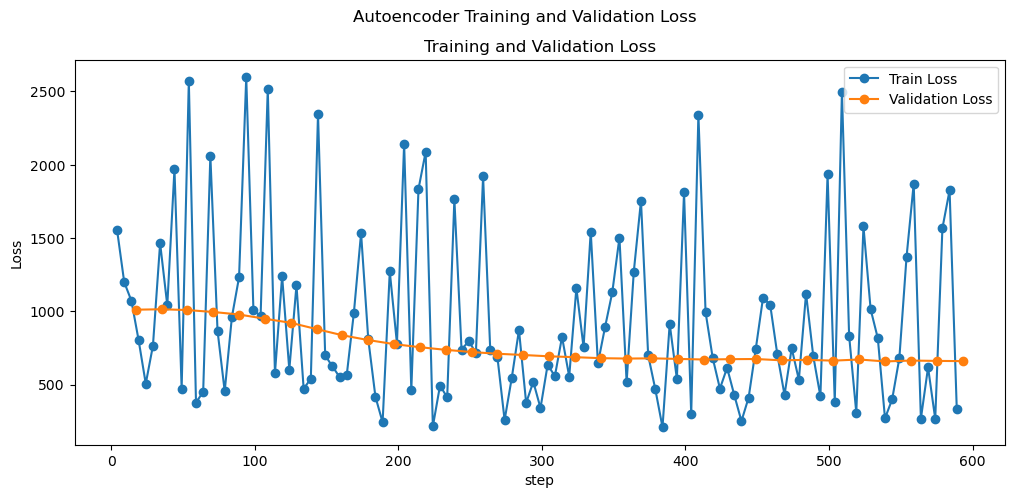

In [15]:
from utils.helper_functions import make_plots


history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")
make_plots(history, "Autoencoder Training and Validation Loss")

In [16]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
!cp {best_model_path} results/03/best_model.pth

In [17]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}

best_model = BaseCancerRegressor.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    auto_encoder=CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        neural_network=SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=study.best_trial.params['n_layers'],
            dropout=study.best_trial.params['dropout'],
            activation=activation_dict[study.best_trial.params['activation']],
        ),
        lr=study.best_trial.params['learning_rate'],
        weight_decay=study.best_trial.params['weight_decay'],
        optimizer=optimizer_dict[study.best_trial.params['optimizer']],
    
)
best_model

BaseCancerRegressor(
  (auto_encoder): CancerDataAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=989, out_features=506, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.013875149619123436, inplace=False)
      (3): Linear(in_features=506, out_features=23, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.013875149619123436, inplace=False)
      (6): Linear(in_features=23, out_features=22, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=22, out_features=505, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.013875149619123436, inplace=False)
      (3): Linear(in_features=505, out_features=988, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.013875149619123436, inplace=False)
      (6): Linear(in_features=988, out_features=989, bias=True)
    )
    (loss_metric): MeanSquaredError()
    (val_metric): MeanSquaredError()
    (test_metric): MeanSquaredError()
  )
  (neural_network): SimpleNN(
    (network): Sequential(
      (0): Lin

In [18]:
joblib.dump(
    best_model,
    f"results/03/best_model_trial_ae_{study.best_trial.number}.pkl",
)

['results/03/best_model_trial_ae_59.pkl']

In [21]:
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

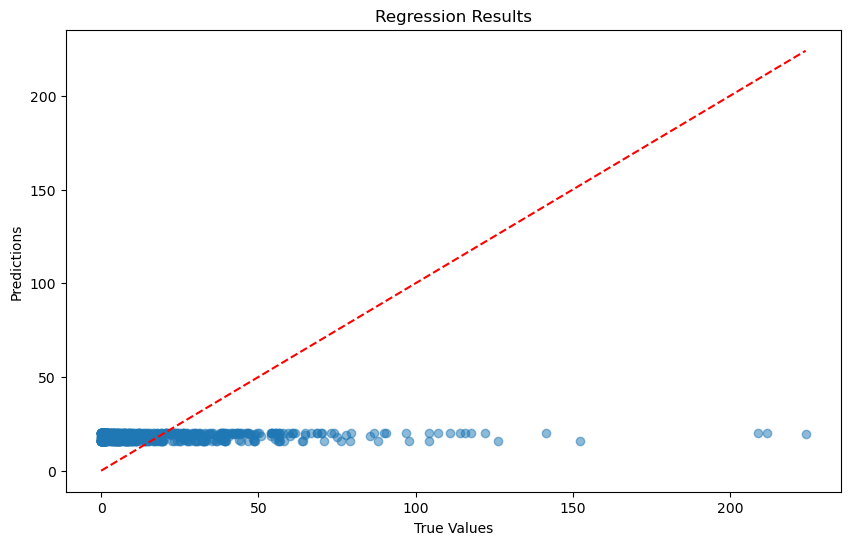

In [24]:
plot_regression_results(best_model.to("cpu"), cancer_dm.train_dataloader())

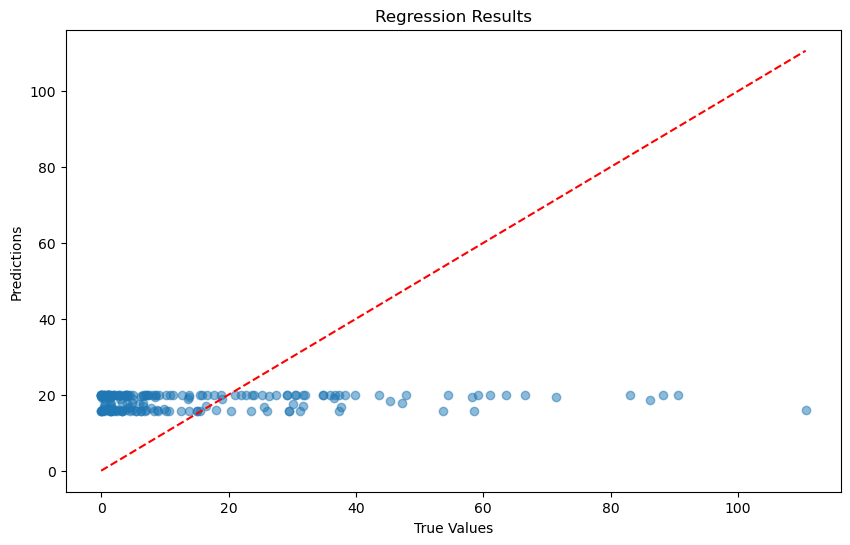

In [23]:
plot_regression_results(best_model.to("cpu"), cancer_dm.test_dataloader())